# Evaluation of multi-omics GRN inference methods
## Preprocess perturbation data
### by Jalil Nourisa

# Imports

In [1]:
import os, binascii
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scanpy as sc
import pandas as pd
import numpy as np
import random
import anndata as ad
from matplotlib.patches import Patch
import warnings
from scipy import sparse
import sys
warnings.filterwarnings("ignore")
sys.path.insert(0, '../')
from src.commons import *
sc.settings.verbosity = 0

warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

work_dir = '../output'
# input_dir = '../input'
results_dir = '../results_folder'
task_grn_dir = '../../task_grn_benchmark'


In [2]:
# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [3]:
import scvi
import scib

In [4]:

plt.rcParams.update({
    'font.size': 10,              # Default text size
    'axes.titlesize': 12,         # Title size of the axes
    'axes.labelsize': 10,         # Size of the x and y labels
    'xtick.labelsize': 10,         # Size of the x tick labels
    'ytick.labelsize': 10,         # Size of the y tick labels
    'legend.fontsize': 10,         # Font size of the legend
    'figure.titlesize': 12,        # Size of the figure title

    'grid.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    'ytick.major.size': 2,
    'ytick.minor.size': 2,
    'grid.alpha': 0.4,
    'grid.color': 'grey',
    'grid.linestyle': '--',
    'axes.linewidth': 0.3  # Controls the border line width
})

In [5]:
aaa

NameError: name 'aaa' is not defined

# EDA on single cell data

In [29]:
sc_counts = ad.read_h5ad(f'{task_grn_dir}/resources/datasets_raw/perturbation_counts.h5ad')
sc_counts.var_names_make_unique()
sc_counts.obs['positive_control'] = sc_counts.obs.sm_name.isin(controls2)

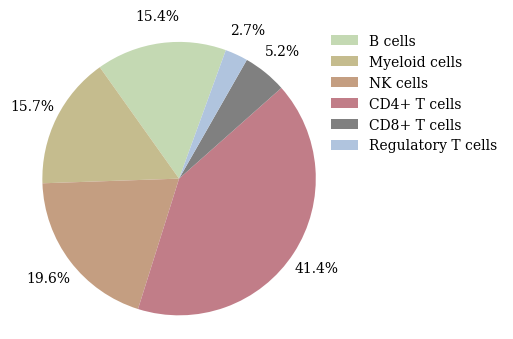

In [30]:
fig, ax = plt.subplots(1,1 , figsize=(5, 3.5))  # Adjust the figure size as needed

ax.pie(
    [15.4, 15.7, 19.6, 41.4, 5.2, 2.7], autopct='%1.1f%%',
    startangle=70, colors=['#c4d9b3', '#c5bc8e', '#c49e81', '#c17d88', 'gray', 'lightsteelblue'], pctdistance=1.2,
)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()


handles = []
for kk, label in enumerate(['B cells', 'Myeloid cells', 'NK cells', 'CD4+ T cells', 'CD8+ T cells', 'Regulatory T cells']):
    handles.append(Patch(facecolor=colors_cell_type[kk], label=label))

ax.legend(handles=handles, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, frameon=False)

plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/celltype_raios_original.png', dpi=100, transparent=True)
plt.show()

In [ ]:
aa

### UMAP before filtering

In [32]:
warnings.simplefilter("ignore")
with warnings.catch_warnings():
    sc.pp.normalize_total(sc_counts)
    sc.pp.log1p(sc_counts)
    sc.pp.highly_variable_genes(sc_counts, n_top_genes=2000)
    sc.tl.pca(sc_counts, svd_solver='arpack', use_highly_variable=True)
    sc.pp.neighbors(sc_counts, n_neighbors=10, n_pcs=50)
    sc.tl.umap(sc_counts)
sc_counts

In [ ]:
from src.local_utils import plots 
figsize = (3.5, 3.5)
fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)
bbox_to_anchor = (-.5, 1)
s = .01
plots.plot_umap(sc_counts, color='cell_type', palette=plots.colors_cell_type, ax=ax, 
                bbox_to_anchor=bbox_to_anchor, s=s, legend=False, alpha=.5)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)
plots.plot_umap(sc_counts, color='donor_id', palette=plots.colors_blind, 
                ax=ax, bbox_to_anchor=bbox_to_anchor, s=s, legend=False, alpha=.5)

ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)
plots.plot_umap(sc_counts, color='positive_control', palette=plots.colors_blind, 
                ax=ax, bbox_to_anchor=bbox_to_anchor, s=s, legend=False, alpha=.5)

ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')


# EDA on pseudobulked data

In [33]:
bulk_adata = ad.read_h5ad(f'{task_grn_dir}/resources_local/pseudobulked_data.h5ad')

sample_n = bulk_adata.shape[0]
gene_n = bulk_adata.shape[1]
obs_index= ['cell_type', 'sm_name']
# some preprocess
bulk_adata.X = np.nan_to_num(bulk_adata.X, nan=0)
bulk_adata

AnnData object with n_obs × n_vars = 2277 × 18248
    obs: 'plate_well_cell_type', 'cell_type', 'sm_name', 'well', 'row', 'donor_id', 'plate_name', 'cell_count'
    layers: 'counts', 'n_counts'

## Gene missigness

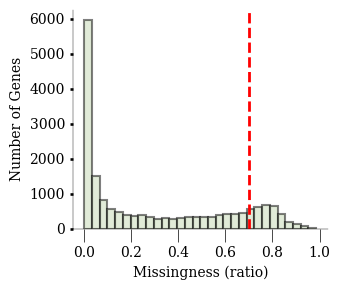

In [34]:
# Calculate missingness for each gene
missingness = (bulk_adata.X == 0).mean(axis=0)
missingness = np.array(missingness).flatten()

# Plot the distribution
fig, ax = plt.subplots(figsize=(3.5, 3))
ax.hist(missingness, bins=30, color=colors_cell_type[0], edgecolor='black', alpha=0.5)
ax.axvline(x=0.7, color='red', linestyle='--', linewidth=2)  # Add a vertical line at 0.7
# ax.set_title('Distribution of Gene Missingness')
ax.set_xlabel('Missingness (ratio)')
ax.set_ylabel('Number of Genes')
ax.spines[['right', 'top']].set_visible(False)
ax.grid(False)

plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/gene_missingness.png', dpi=150, transparent=True)
plt.show()

In [35]:
print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)

ratio of missingness 0.2971925668826342


## Cell count distribution: compound based  

In [36]:
from src.local_utils import isolation_forest
from src.plots import plot_stacked_bar_chart

In [37]:
outliers_toxic = ['Alvocidib', 'UNII-BXU45ZH6LI', 'CGP 60474', 'BMS-387032']
outliers_two_celltype = ['CEP-18770 (Delanzomib)', 'IN1451', 'MLN 2238', 'Oprozomib (ONX 0912)']
outliers_misbalance_donor_2 = ['Vorinostat']
outliers_misbalance_all = ['Proscillaridin A;Proscillaridin-A']
outliers_misbalance_donor_3 = ['AT13387', 'Ganetespib (STA-9090)']
outlier_compounds = outliers_toxic + outliers_two_celltype + outliers_misbalance_all + outliers_misbalance_donor_2 + outliers_misbalance_donor_3

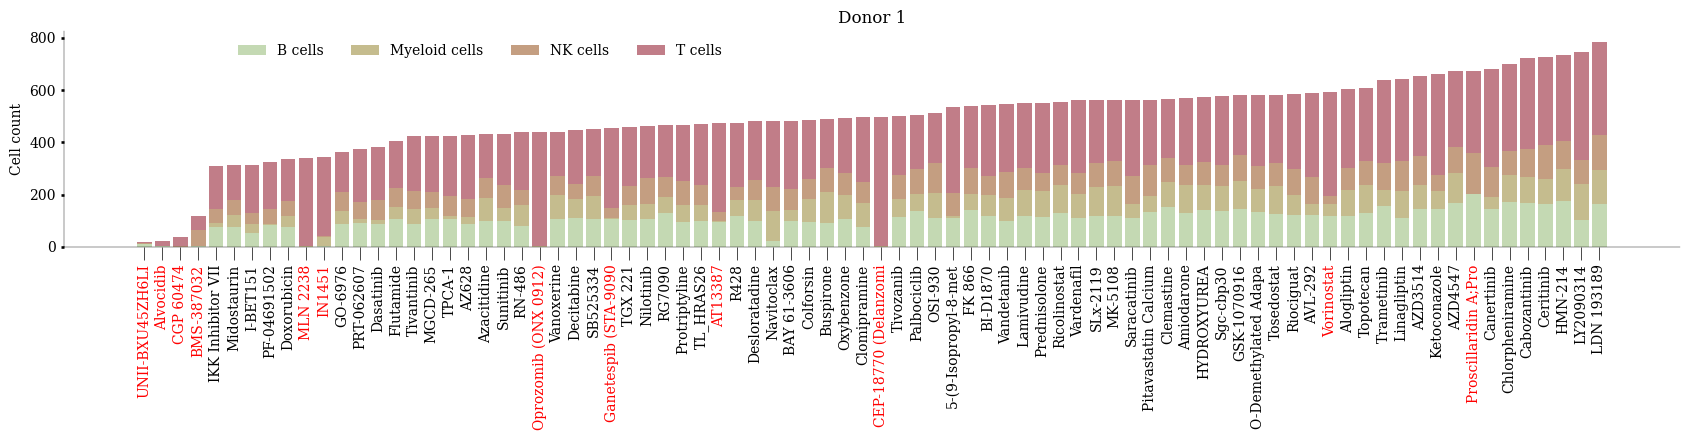

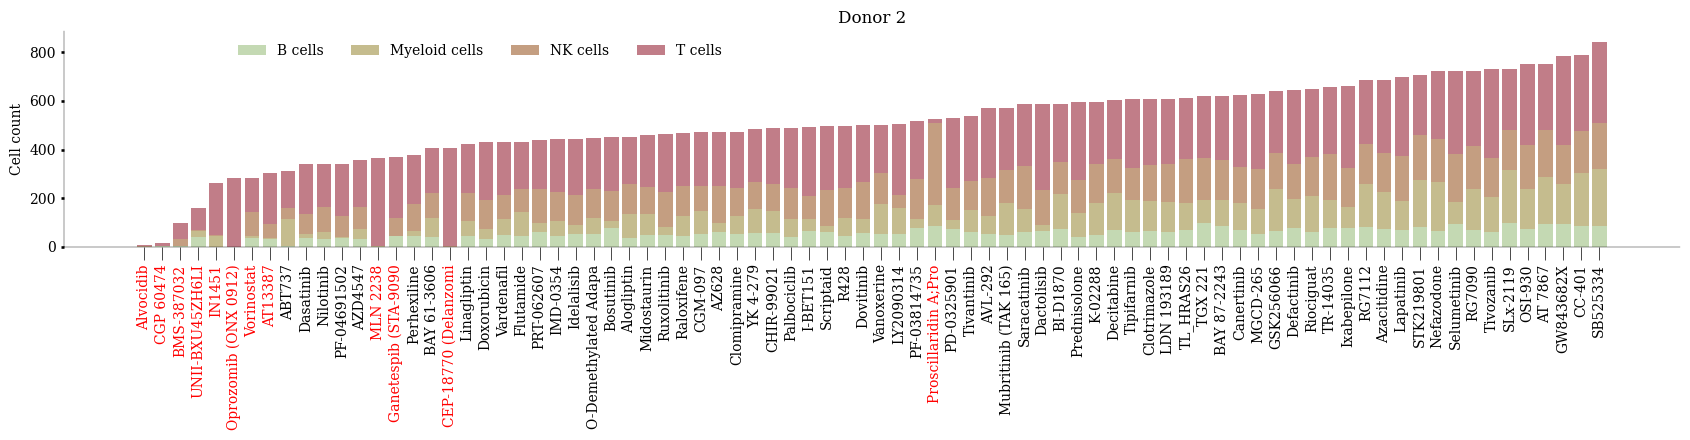

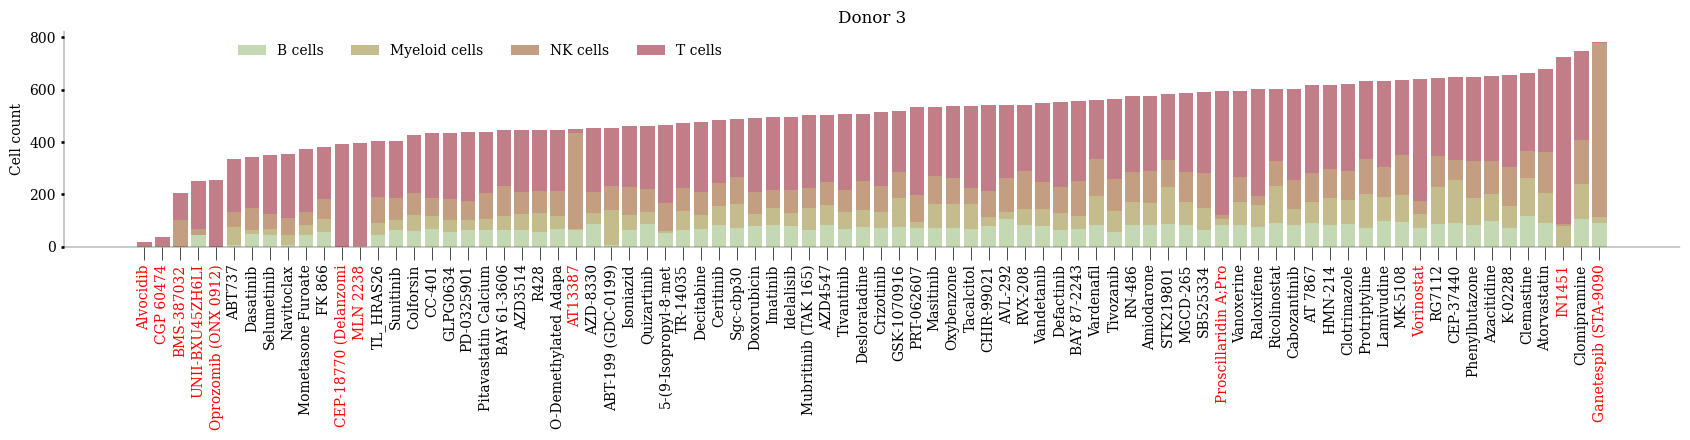

In [38]:
bulk_adata_non_controls = bulk_adata[~bulk_adata.obs.sm_name.isin(controls3), :]
donor_ids = bulk_adata.obs.donor_id.unique()
outliers_list = []
for i_donor, donor_id in enumerate(donor_ids):
    # subset and format data
    df_subset = bulk_adata_non_controls.obs[bulk_adata_non_controls.obs.donor_id==donor_id][['sm_name', 'cell_type', 'cell_count']]
    cell_count_m = df_subset.pivot(index='sm_name', columns='cell_type', values='cell_count')
    cell_count_m = cell_count_m.fillna(0)

    # outlier 
    outliers_if = isolation_forest(df_subset, group=['sm_name'])    
    outliers_list.append(outliers_if)
    
    # save the order
    # if i_donor==0:
    
    cell_count_m['sum'] = cell_count_m.sum(axis=1)
    cell_count_m = cell_count_m.sort_values('sum')
    cell_count_m = cell_count_m.drop(columns='sum')
    saved_order = cell_count_m.index
            
    # else:
    #     cell_count_m = cell_count_m.reindex(saved_order)

    colors = []
    masks = []
    for label in cell_count_m.index.values:
        if label in outlier_compounds:
            colors.append('red')
            mask = True
        else:
            colors.append('black')
            np.random.seed(32)
            mask = np.nan
        masks.append(mask)
    masks = np.asarray(masks)
    nan_mask = np.isnan(masks)
    random_bool = np.random.choice([True, False],size=nan_mask.sum())
    masks[nan_mask] = random_bool
    
    if True: # show only some of non outlier compounds
        cell_count_m['mask'] = masks
        cell_count_m['color'] = colors
        cell_count_m = cell_count_m[cell_count_m['mask']==True]
        colors = cell_count_m['color'].values
        cell_count_m = cell_count_m.drop(columns=['mask', 'color'])
    # save the order
    
    xticklabels = cell_count_m.index.values
    xticklabels = [item[0:20] for item in xticklabels]
    fig, ax = plot_stacked_bar_chart(cell_count_m, title=donor_id, xticklabels=xticklabels, colors=colors, figsize=(17, 4.5))
    ax.legend(ncol=4, frameon=False, loc='upper left', bbox_to_anchor=(.1,1))
    ax.set_ylabel('Cell count')
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    plt.tight_layout()
    fig.savefig(f'{work_dir}/preprocess/figs/outliers_{donor_id}.png', dpi=150, transparent=True)

all_outliers = np.unique(np.concatenate(outliers_list))
common_outliers = list(set(outliers_list[0]).intersection(outliers_list[1], outliers_list[2]))


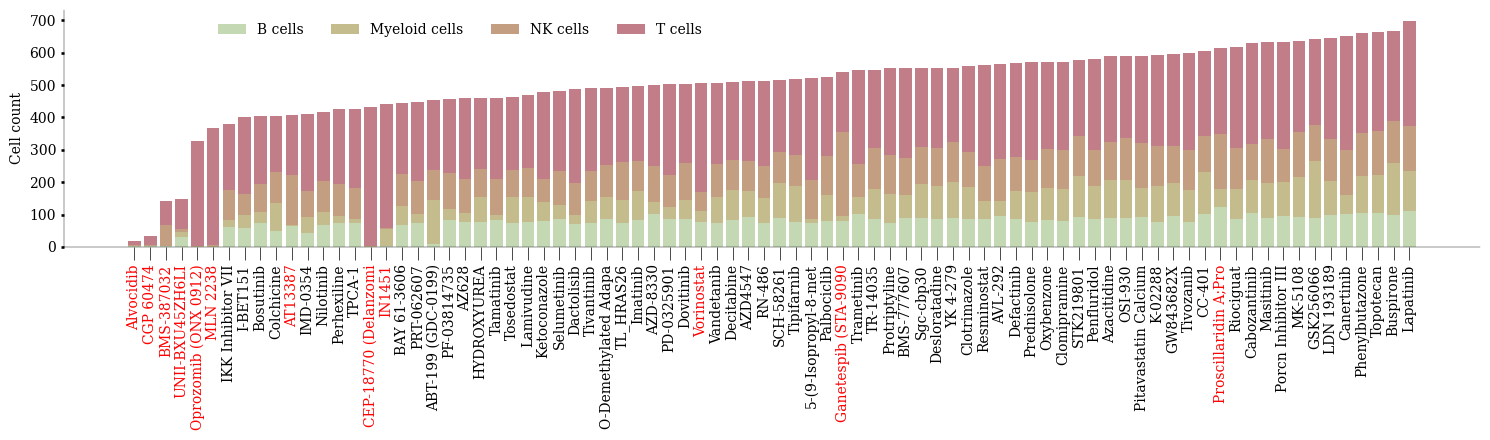

In [39]:
# average across 
df_subset = bulk_adata_non_controls.obs.groupby(['sm_name', 'cell_type']).apply(lambda df:df['cell_count'].mean()).to_frame().reset_index()
cell_count_m = df_subset.pivot(index='sm_name', columns='cell_type', values=0)
cell_count_m = cell_count_m.fillna(0)

# save the order
cell_count_m['sum'] = cell_count_m.sum(axis=1)
cell_count_m = cell_count_m.sort_values('sum')
cell_count_m = cell_count_m.drop(columns='sum')
saved_order = cell_count_m.index

colors = []
masks = []
for label in cell_count_m.index.values:
    if label in outlier_compounds:
        colors.append('red')
        mask = True
    else:
        colors.append('black')
        np.random.seed(32)
        mask = np.nan
    masks.append(mask)
masks = np.asarray(masks)
nan_mask = np.isnan(masks)
random_bool = np.random.choice([True, False],size=nan_mask.sum())
masks[nan_mask] = random_bool

if True: # show only some of non outlier compounds
    cell_count_m['mask'] = masks
    cell_count_m['color'] = colors
    cell_count_m = cell_count_m[cell_count_m['mask']==True]
    colors = cell_count_m['color'].values
    cell_count_m = cell_count_m.drop(columns=['mask', 'color'])
# save the order

xticklabels = cell_count_m.index.values
xticklabels = [item[0:20] for item in xticklabels]
fig, ax = plot_stacked_bar_chart(cell_count_m, title='', xticklabels=xticklabels, colors=colors, figsize=(15, 4.5))
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.legend(ncol=4, frameon=False, loc='upper left', bbox_to_anchor=(.1,1))
ax.set_ylabel('Cell count')
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/outliers_mean.png', dpi=150, transparent=True)

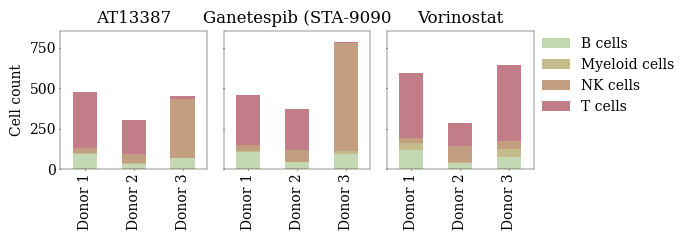

In [40]:
# group_to_plot = np.setdiff1d(all_outliers, common_outliers)
# group_to_plot = np.setdiff1d(common_outliers, included_outliers)
group_to_plot = ['AT13387', 'Ganetespib (STA-9090)', 'Vorinostat']

def plot_stacked_bar_chart(cell_types_in_drops, title='', xticks=None, 
                           xticklabels=None, colors=None, figsize=(25, 4), 
                           ax=None, legend=False, color_map=None):
    """
        Stacked bar plot to showcase the compound based distribution of cell counts. Adopted from AmbrosM. 
    """
    # Add a column of zeros to the left and compute the cumulative sums
    cc = np.hstack([np.zeros((len(cell_types_in_drops), 1)), cell_types_in_drops])
    cc_cs = cc.cumsum(axis=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    cell_types = cell_types_in_drops.columns
    for i, cell_type in enumerate(cell_types):
        if color_map is None:
            color=colors_cell_type[i]
        else:
            color=color_map[cell_type]
        ax.bar(np.arange(len(cc_cs)),
               cc_cs[:,i+1] - cc_cs[:,i],
               bottom=cc_cs[:,i],
               label=cell_types[i], color=color, width=.5)
         
    ax.set_title(title)
    if xticks is not None:
        ax.set_xticks(xticks)
    else:
        ax.set_xticks(np.arange(len(cc_cs)))
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, rotation=90)
    if colors is not None:
        for ticklabel, color in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(color)
    if legend: 
        ax.legend()
    color_legend_handles = [
        matplotlib.patches.Patch(facecolor='red', label='-'),
        matplotlib.patches.Patch(facecolor='blue', label='-'),
        matplotlib.patches.Patch(facecolor='green', label='-'),
    ]
    return fig, ax

fig, axes = plt.subplots(1, 3, figsize=(7, 2.5), sharey=True)

ax_list = []
for i_compound, compound in enumerate(group_to_plot):
    ax = axes[i_compound]
    # subset and format data
    df_subset = bulk_adata.obs[bulk_adata.obs.sm_name==compound][['donor_id', 'cell_type', 'cell_count']]
    cell_count_m = df_subset.pivot(index='donor_id', columns='cell_type', values='cell_count')
    cell_count_m = cell_count_m.fillna(0)
    
    ax.set_ylim([0, 850])
    plot_stacked_bar_chart(cell_count_m, title=compound[0:20], xticklabels=cell_count_m.index.values, colors=None, figsize=(4, 4), ax=ax, legend=False)
    ax_list.append(ax)
    ax.tick_params(axis='both', which='major', length=1, width=.5, direction='out', pad=2)
    ax.margins(.1)
ax_list[0].set_ylabel('Cell count')

ax_list[2].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)


plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/single_compound_outliers.png', dpi=150, transparent=True)


## Missing counts

In [41]:
from src.plots import plot_stratified_scatter

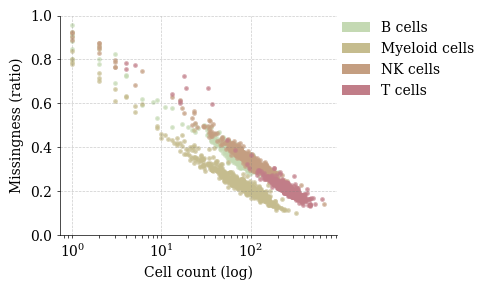

In [46]:
missingness = (bulk_adata.X == 0).sum(axis=1)/bulk_adata.X.shape[1]
bulk_adata_df = pd.DataFrame(bulk_adata.X)

xs = bulk_adata.obs.cell_count
ys = missingness


fig, ax = plt.subplots(1, 1, figsize=(5,3), sharey=False)

plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys, palette=colors_cell_type, log_x=True, x_label='Cell count (log)', y_label='Missingness (ratio)')
ax.set_ylim([0, 1])
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/missigness.png', dpi=150, transparent=True)


In [ ]:
aaa

NameError: name 'aaa' is not defined

# Evaluation of data 

In [47]:
method_names = ['n_counts', 'lognorm', 'pearson', 'seurat_lognorm', 'seurat_pearson', 'scgen_lognorm', 'scgen_pearson']

In [48]:
bulk_adata = ad.read(f'{task_grn_dir}/resources/grn-benchmark/perturbation_data.h5ad')
bulk_adata

AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'donor_id', 'sm_name', 'plate_name', 'well', 'cell_type', 'row', 'cell_count'
    uns: 'X_name'
    layers: 'counts', 'lognorm', 'n_counts', 'pearson', 'scgen_lognorm', 'scgen_pearson', 'seurat_lognorm', 'seurat_pearson'

In [49]:
bulk_adata.obs['positive_control'] = bulk_adata.obs.sm_name.isin(controls2)
bulk_adata.obs['negative_control'] = bulk_adata.obs.sm_name.eq(negative_control)
bulk_adata

AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'donor_id', 'sm_name', 'plate_name', 'well', 'cell_type', 'row', 'cell_count', 'positive_control', 'negative_control'
    uns: 'X_name'
    layers: 'counts', 'lognorm', 'n_counts', 'pearson', 'scgen_lognorm', 'scgen_pearson', 'seurat_lognorm', 'seurat_pearson'

In [50]:
bulk_adata.obs.sm_name.unique().shape

(138,)

## Pseudobulked: mean vs sum 

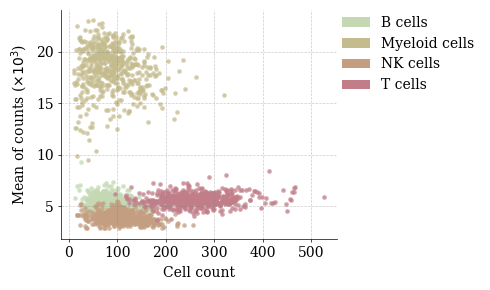

In [63]:
# cell type 
from local_utils import plots
fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharey=False)

# mean 
method = 'n_counts'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.obs.cell_count
ys = bulk_adata.X.sum(axis=1)

ys = ys/1E3 
bbox_to_anchor = (1, 1)
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys,bbox_to_anchor=bbox_to_anchor, palette=colors_cell_type, x_label='Cell count', y_label='Mean of counts ($\\times 10^3$)')
plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/mean_pseudobulked.png',dpi=300, transparent=True, bbox_inches='tight')


## Pseudobulked: std vs cell count 

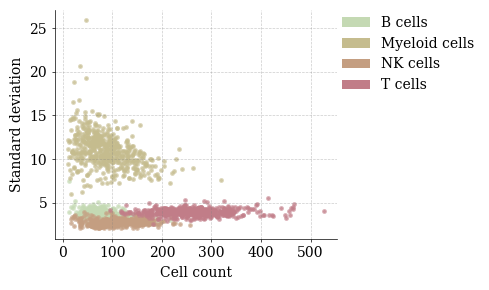

In [66]:
# cell type 
from local_utils import plots
fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharey=False)

# mean 
method = 'n_counts'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.obs.cell_count
ys = bulk_adata.X.std(axis=1)

bbox_to_anchor = (1, 1)
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys,bbox_to_anchor=bbox_to_anchor, palette=colors_cell_type, x_label='Cell count', y_label='Standard deviation')

plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/mean_pseudobulked_std_cellcount.png',dpi=300, transparent=True, bbox_inches='tight')



## Normalization: std vs sum of normalized data 

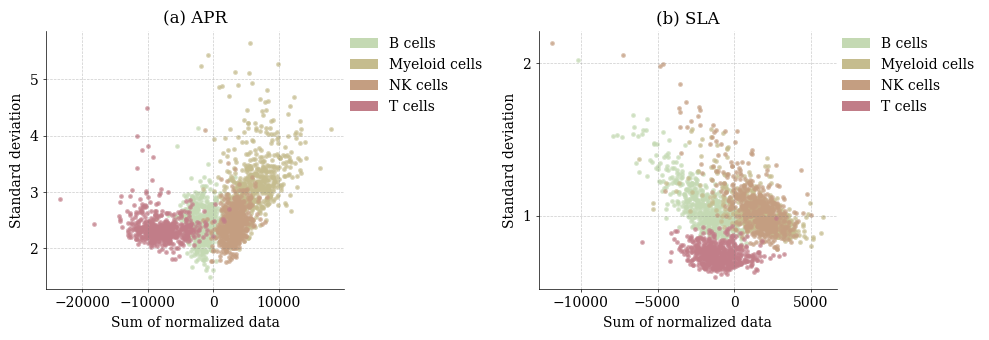

In [55]:
# APR
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=False)

method = 'pearson'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.X.sum(axis=1)
ys = bulk_adata.X.std(axis=1)


ax = axes[0]
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys, palette=colors_cell_type,x_label='Sum of normalized data', y_label='Standard deviation')
ax.set_title('(a) APR')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))


method = 'lognorm'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.X.sum(axis=1)
ys = bulk_adata.X.std(axis=1)


ax = axes[1]
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys,palette=colors_cell_type, x_label='Sum of normalized data', y_label='Standard deviation')
ax.set_title('(b) SLA')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
# fig.savefig(f'{work_dir}/preprocess/figs/std_vs_mean_normalized.png',dpi=300, transparent=True, bbox_inches='tight')


## Batch corrected: std vs sum of normalized data 

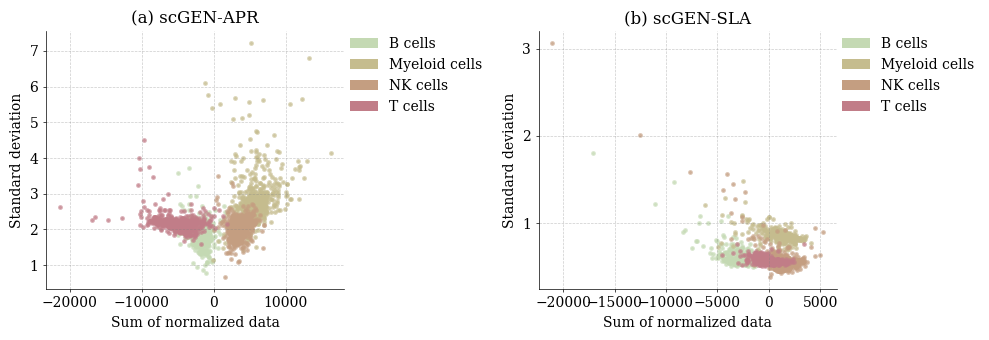

In [56]:
# APR
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=False)

method = 'scgen_pearson'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.X.sum(axis=1)
ys = bulk_adata.X.std(axis=1)


ax = axes[0]
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys, palette=colors_cell_type,x_label='Sum of normalized data', y_label='Standard deviation')
ax.set_title('(a) scGEN-APR')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))


method = 'scgen_lognorm'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.X.sum(axis=1)
ys = bulk_adata.X.std(axis=1)

ax = axes[1]
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys,palette=colors_cell_type, x_label='Sum of normalized data', y_label='Standard deviation')
ax.set_title('(b) scGEN-SLA')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/sum_vs_mean_scgen_sla.png',dpi=300, transparent=True, bbox_inches='tight')


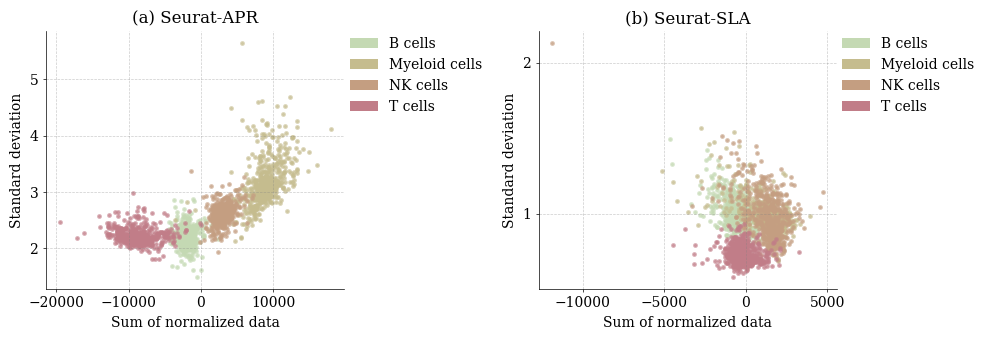

In [57]:
# APR
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=False)

method = 'seurat_pearson'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.X.sum(axis=1)
ys = bulk_adata.X.std(axis=1)


ax = axes[0]
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys, palette=colors_cell_type,x_label='Sum of normalized data', y_label='Standard deviation')
ax.set_title('(a) Seurat-APR')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))


method = 'seurat_lognorm'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.X.sum(axis=1)
ys = bulk_adata.X.std(axis=1)

ax = axes[1]
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys,palette=colors_cell_type, x_label='Sum of normalized data', y_label='Standard deviation')
ax.set_title('(b) Seurat-SLA')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/sum_vs_mean_seurat_sla.png',dpi=300, transparent=True, bbox_inches='tight')


## UMAP

In [58]:
strong_compounds = ['Belinostat', 'Vorinostat', 'Scriptaid', 'Resminostat']

mask = bulk_adata.obs.sm_name.isin(strong_compounds)
bulk_adata.obs.loc[mask,'sm_name_5'] = bulk_adata.obs.sm_name[mask].astype(str)
bulk_adata.obs.loc[~mask,'sm_name_5'] = 'Rest'

In [59]:

def plot_umap(adata, color='', X_label='X_umap',  palette=None, ax=None, 
              bbox_to_anchor=None, legend=True, legend_title='', **kwrds):
    latent = adata.obsm[X_label]
    var_unique_sorted = sorted(adata.obs[color].unique())
    if 'Rest' in var_unique_sorted:
        var_unique_sorted.remove('Rest')
        # Sort the list without 'Rest'
        var_unique_sorted = sorted(var_unique_sorted)
        # Append 'Rest' to the end of the sorted list
        var_unique_sorted.append('Rest')

    print(var_unique_sorted)
    legend_handles = []
    
    for i_group, group in enumerate(var_unique_sorted):
        mask = adata.obs[color] == group
        sub_data = latent[mask]
        
        if palette is None:
            c = None 
        else:
            c = palette[i_group]

        if group=='Rest':
            alpha=.1
            s=.5
        else:
            alpha=.8
            s=4
        
        scatter = ax.scatter(sub_data[:, 0], sub_data[:, 1], label=group, **kwrds, c=c, alpha=alpha,s=s)
        legend_handles.append(plt.Line2D([0], [0], linestyle='none', marker='o', markersize=8, color=scatter.get_facecolor()[0]))
        
        if color == 'leiden':
            mean_x = np.mean(sub_data[:, 0])
            mean_y = np.mean(sub_data[:, 1])
            ax.text(mean_x, mean_y, group, fontsize=9, ha='center', va='top', color='black', weight='bold')

    ax.spines[['right', 'top']].set_visible(False)

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')

    ax.set_xticks([])
    ax.set_yticks([])
    # ax.margins(0.4)
    if legend and color != 'leiden':
        legend  =ax.legend(handles=legend_handles, labels=var_unique_sorted, loc='upper left', 
                  bbox_to_anchor=bbox_to_anchor, frameon=False, title=legend_title, title_fontproperties={'weight': 'bold',  'size':9})
        legend.get_title().set_ha('left')

        # Increase the distance between the title and legend entries
        legend._legend_box.align = "left"  # Align the entries to the left
        # legend._legend_box.set_spacing(2)  # Increase the spacing between the title and entries

In [60]:
color_compounds = ['Cyan']+ plots.colors_blind[4:4+3] +['grey']

['Belinostat', 'Resminostat', 'Scriptaid', 'Vorinostat', 'Rest']
['Belinostat', 'Resminostat', 'Scriptaid', 'Vorinostat', 'Rest']


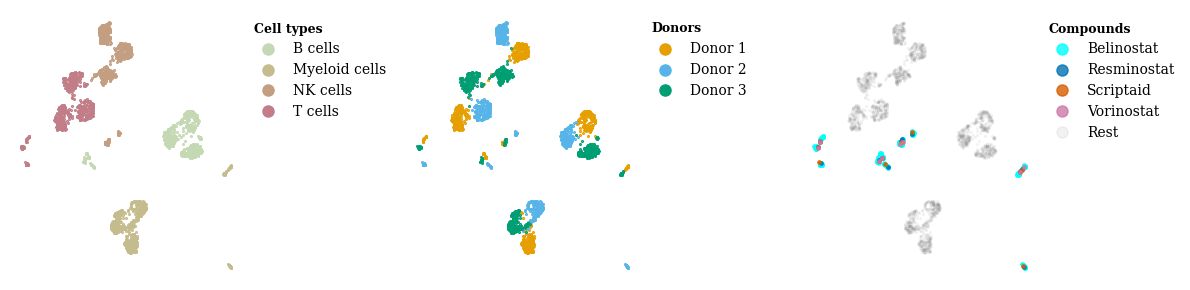

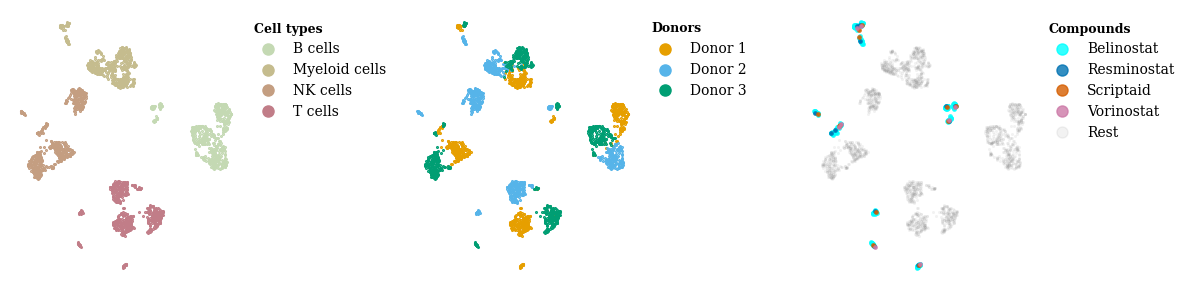

In [67]:
from src import plots
figsize = (12, 3) #3
pad=20
for layer in ['lognorm', 'pearson']:
    # normalized SLA
    bulk_adata_c = bulk_adata.copy()
    bulk_adata_c.X = bulk_adata_c.layers[layer]
    sc.pp.neighbors(bulk_adata_c)
    sc.tl.leiden(bulk_adata_c, resolution=.5)
    sc.tl.umap(bulk_adata_c)

    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=False)
    ax = axes[0]
    s = .5
    bbox_to_anchor = (1, 1)
    plots.plot_umap(bulk_adata_c, color='cell_type', legend_title='Cell types', palette=colors_cell_type, ax=ax, bbox_to_anchor=bbox_to_anchor, s=s)
    # ax.set_title('Cell type', pad=pad)
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax = axes[2]

    plot_umap(bulk_adata_c, color='sm_name_5', legend_title='Compounds', palette=color_compounds, ax=ax, bbox_to_anchor=bbox_to_anchor)
    # ax.set_title('Positive control',pad=pad)
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax = axes[1]

    plots.plot_umap(bulk_adata_c, color='donor_id', legend_title='Donors', palette=colors_blind, ax=ax, bbox_to_anchor=bbox_to_anchor, s=s)
    # ax.set_title('Donor',pad=pad)
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.tight_layout()

    fig.savefig(f'{work_dir}/preprocess/figs/umap_perturbation_{layer}.png', dpi=300, transparent=True, bbox_inches='tight')

In [68]:
# ncorrected data
bulk_adata_c = bulk_adata.copy()
bulk_adata_c.X = bulk_adata_c.layers['scgen_pearson']
sc.pp.neighbors(bulk_adata_c)
sc.tl.leiden(bulk_adata_c, resolution=.5)
sc.tl.umap(bulk_adata_c)

['Belinostat', 'Resminostat', 'Scriptaid', 'Vorinostat', 'Rest']


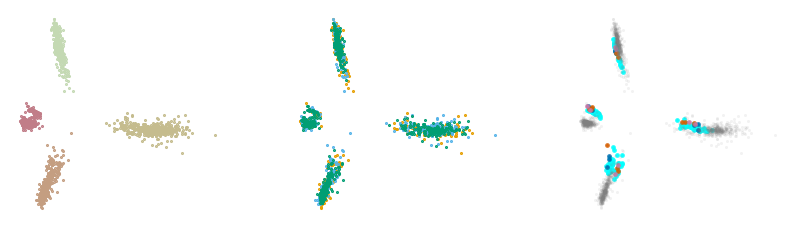

In [69]:
from src import plots
figsize = (10, 2.7) #3
pad=20
fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=False)
fig.subplots_adjust(wspace=.3) 
ax = axes[0]
s = .5
bbox_to_anchor = (.8, 1)
plots.plot_umap(bulk_adata_c, X_label='X_pca', color='cell_type', legend_title='Cell types', palette=colors_cell_type, ax=ax, bbox_to_anchor=bbox_to_anchor, s=s,legend=False)
# ax.set_title('Cell type', pad=pad)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

ax = axes[2]

plot_umap(bulk_adata_c, color='sm_name_5', X_label='X_pca', legend_title='Compounds', palette=color_compounds, ax=ax, bbox_to_anchor=bbox_to_anchor, legend=False)
# ax.set_title('Positive control',pad=pad)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

ax = axes[1]

plots.plot_umap(bulk_adata_c, X_label='X_pca', color='donor_id', legend_title='Donors', palette=colors_blind, ax=ax, bbox_to_anchor=bbox_to_anchor, s=s, legend=False)
# ax.set_title('Donor',pad=pad)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

# plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/umap_perturbation_corrected_pearson.png', dpi=300, transparent=True, bbox_inches='tight')



## Batch correction evaluation


In [70]:
aa 

NameError: name 'aa' is not defined

In [ ]:
layers = ['n_counts','lognorm','pearson', 'seurat_lognorm', 'seurat_pearson', 'scgen_lognorm', 'scgen_pearson']


In [ ]:

bulk_adata = ad.read_h5ad(f"{input_dir}/bulk_adata_integrated.h5ad")
bulk_adata

In [ ]:
df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)
housekeeping_genes = df.loc[:, 0]  # Gene names
print(f'Number of housekeeping genes: {len(housekeeping_genes)}')
# housekeeping_genes_filter = gene_names.isin(housekeeping_genes)

In [ ]:
from src.explanatory_analysis import calculate_percentile_rank
def run_pr(adata, layer):
    data = adata.layers[layer].copy()
    rr_df = pd.DataFrame()
    mask = bulk_adata.obs.positive_control
    rr_df['Positive control'] = [calculate_percentile_rank(data, mask)/100]
    rr_df['Positive control'] = 1-rr_df['Positive control'] 
    mask = bulk_adata.obs.sm_name == negative_control
    rr_df['Negative control'] = [calculate_percentile_rank(data, mask)/100]


    mask = bulk_adata.var_names.isin(housekeeping_genes)
    rr_df['HKGs'] = [calculate_percentile_rank(data.T, mask)/100]

    mask = bulk_adata.obs.cell_type == 'myeloid cells'
    rr_df['Myeloid cells'] = [calculate_percentile_rank(data, mask)/100]
    rr_df['Myeloid cells'] = 1-rr_df['Myeloid cells'] 

    return rr_df

In [ ]:
# local imports
sys.path.insert(0, '../')
from src.local_utils import run_scib, run_classifier

def run_metrics(bulk_adata, layer='lognorm', batch_key='plate_name', label_key='cell_type'):
    rr = run_scib(bulk_adata, layer=layer, layer_baseline='n_counts', batch_key=batch_key, label_key=label_key)
    # print("classifier")
    # rr_classifier = run_classifier(bulk_adata, layer, batch_key)
    
    rr_pr = run_pr(bulk_adata, layer=layer)

    rr = pd.concat([rr, rr_pr], axis=1)
    rr.index = [layer]
    return rr

for i, layer in enumerate(layers):
    print('\n', layer)
    rr = run_metrics(bulk_adata, layer=layer, batch_key=batch_key, label_key=label_key)
    if i == 0:
        rr_all = rr 
    else:
        rr_all = pd.concat([rr_all, rr], axis=0)
    print(rr_all)
    rr_all.to_csv(f'{results_dir}/preprocessing/batch_correction_metrics.csv')

In [ ]:
rr_all = pd.read_csv(f'{results_dir}/preprocessing/batch_correction_metrics.csv', index_col=0)
rr_all.round(2).style.background_gradient()

In [ ]:
# plot
import seaborn

datasets = ['Pseudobulked', 'SLA', 'APR',  'Seurat-SLA', 'Seurat-APR', 'scGEN-SLA', 'scGEN-APR']
rr_all.index = datasets

vmin = np.nanmin(rr_all)
vmax = np.nanmax(rr_all)
fig, ax = plt.subplots(1, 1, figsize=(9, 3.5), sharey=True, sharex=True)

seaborn.heatmap(rr_all, ax=ax, square=False, cbar=False, annot=True, fmt='.2f', vmin=vmin, vmax=vmax)
ax.tick_params(left=False, bottom=False)
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=15, ha="center")

plt.tight_layout()

# plt.savefig(f'{results_folder}/figs/first-validation-heatmap.png', dpi=300, transparent=True,  bbox_inches='tight')

In [ ]:
df = pd.read_csv('../output/preprocess/batch_correction/scores.csv', index_col=0).T
df.dropna(axis=1).style.background_gradient()

In [ ]:
rename_methods = lambda items:[item.replace('n_counts','Pseudobulked (mean)').replace('_', '-').replace('scgen','scGen').replace('seurat','Seurat').replace('lognorm','SLA').replace('pearson','APR') for item in items]
rename_metrics =  lambda items:[item.replace('_', ' ').replace('hvg','HVG').replace('cell','Cell') for item in items]

In [ ]:
batch_labels = ["ASW label", "kBET", "PCR batch", "iLISI"]
bio_labels = ["NMI cluster/label", "ARI cluster/label", "HVG overlap", "Cell cycle conservation"]

In [ ]:
# remove some metrixs
metrics_to_go = ['ASW_label/batch', 'isolated_label_F1', 'isolated_label_silhouette', 'graph_conn', 'trajectory']
rr_all = rr_all.drop(metrics_to_go, errors='ignore')
# fix naming
rr_all.index.name = ''

# select what to see
scores_scib_df = rr_all.T

scores_scib_df.columns = rename_metrics(scores_scib_df.columns)
scores_scib_df.index = rename_methods(scores_scib_df.index)

all_included_labels = bio_labels + batch_labels 
scores_scib_df = scores_scib_df[all_included_labels]

scores_scib_df.style.background_gradient(cmap="Blues")

### Plot scores

In [ ]:
scores_all_df = pd.read_csv(f'{work_dir}/preprocess/batch_correction/scores_all_df.csv', index_col=0)
scores_all_df

In [ ]:
scores_scaled = (scores_all_df - scores_all_df.min()) / (scores_all_df.max() - scores_all_df.min())

if 'PR similarity' not in bio_labels:
    bio_labels.append('PR similarity')

scores_scaled["Batch correction"] = scores_all_df[batch_labels].mean(axis=1)
scores_scaled["Bio conservation"] = scores_all_df[bio_labels].mean(axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.rcParams.update({
    'font.size': 10,              # Default text size
    'axes.titlesize': 12,         # Title size of the axes
    'axes.labelsize': 10,         # Size of the x and y labels
    'xtick.labelsize': 10,         # Size of the x tick labels
    'ytick.labelsize': 10,         # Size of the y tick labels
    'legend.fontsize': 10,         # Font size of the legend
    'figure.titlesize': 12,        # Size of the figure title

    'grid.linewidth': 0.5,
    'xtick.major.width': 0.1,
    'xtick.minor.width': 0.1,
    'ytick.major.size': 1,
    'ytick.minor.size': 1,
    'grid.alpha': 0.4,
    'grid.color': 'grey',
    'grid.linestyle': '--',
    'axes.linewidth': 0.1  # Controls the border line width
})
for i_label, (label, row) in enumerate(scores_scaled.iterrows()):
    ax.scatter(row["Batch correction"], row["Bio conservation"], label=label, s=15, c=colors_blind[i_label])

ax.set_xlabel("Batch correction")
ax.set_ylabel("Bio-conservation")
ax.set_xlim([0,1])
ax.set_ylim([0,1.1])
# annotate methods 
offsets = {'scGen-APR':(-14,9), 'scGen-SLA':(-52, -12), 'Seurat-SLA':(0,-15)}
for ii, (k, v) in enumerate(scores_scaled[["Batch correction", "Bio conservation"]].iterrows()):
    offset = offsets.get(k)
    if offset is None:
        offset = (6,3)
    ax.annotate(
        k,
        v,
        color=colors_blind[ii],
        size=10,
        alpha=.8,
        xytext=offset,
        textcoords="offset points",
    )
ax.margins(0.05)
ax.tick_params(axis='both', which='major', length=2, width=1, direction='out', pad=2)
for spine in ax.spines.values():
        spine.set_linewidth(0.5)  # Adjust the border thickness here

ax.spines[['right', 'top']].set_visible(False)
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')

# plt.show()
fig.savefig(f'{work_dir}/preprocess/figs/correction_scores.png', dpi=300, transparent=True, bbox_inches='tight')